# HR Diagram

In this notebook we'll show you how to make an HR diagram of nearby field stars and a cluster, and use this to determine their relative distances.

You don't have to cut and paste code - if you clone this git repository `https://github.com/benjaminpope/ladder`, these examples will be available under `docs/notebooks`.

First, we'll load all the Python packages we need.

In [1]:
import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

import os 

import pandas as pd # pandas is a popular library in industry for manipulating large data tables

# configure notebook for plotting
%matplotlib inline 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

# define default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 

import warnings
warnings.filterwarnings('ignore')

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_1752/2746787847.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme


## Load some data

Let's pick a data directory from files I prepared earlier. These were from an earlier run of the universe-making code and don't belong to any group in this project!

Here, `ddir` should be the data directory for the camera where your stars are. The `..` means the directory above the one you are currently working in - it is important that this path points to where **your** data live, or else the code won't know where to look!

In [7]:
ddir = '/Users/benjaminpope/Downloads/universe_6683/' # this should be where you unzipped your data

In [11]:
stars = pd.read_csv(ddir+'Top/Star_Data.csv') 
print(stars.keys()) # this tells us what column names we have

Index(['Name', 'X', 'Y', 'BlueF', 'GreenF', 'RedF', 'Parallax',
       'RadialVelocity', 'Variable?'],
      dtype='object')


It looks like we have a bunch of clusters of galaxies here! Space is big!

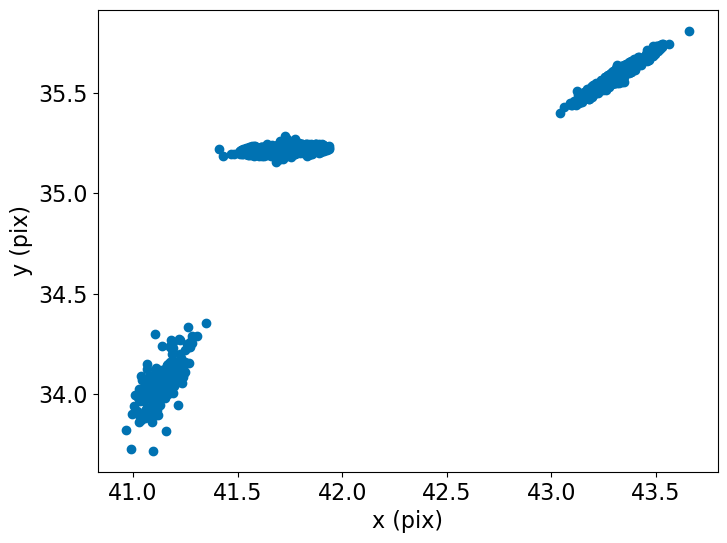

In [12]:
plt.scatter(stars.X,stars.Y)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)');

So let's focus in on one of them in the top right:

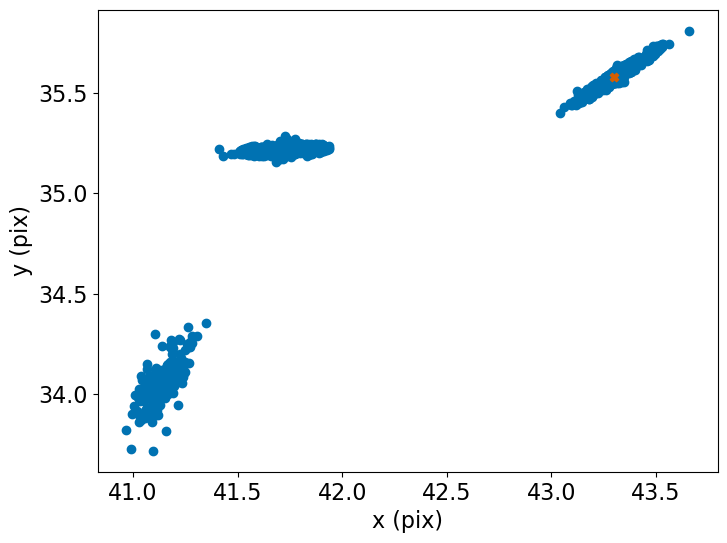

In [21]:
centre = (43.3, 35.58)
plt.scatter(stars.X,stars.Y)
plt.scatter(*centre,color='C2',marker='X') # * expands the elements of a list 
plt.xlabel('x (pix)')
plt.ylabel('y (pix)');

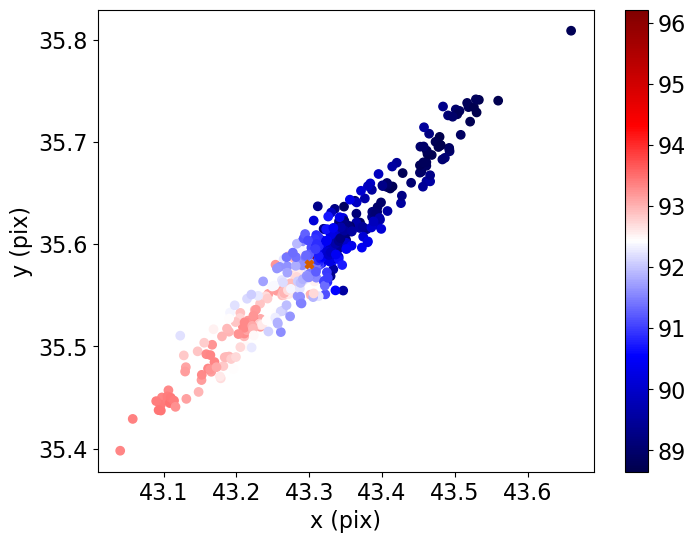

In [24]:
d = np.sqrt((stars.X-centre[0])** 2 + (stars.Y - centre[1])**2)
galaxy = stars[d<1] # filter to only close ones
plt.scatter(galaxy.X,galaxy.Y,c=galaxy.RadialVelocity,cmap=mpl.cm.seismic) # let's overplot the radial velocities
plt.colorbar()
plt.scatter(*centre,color='C2',marker='X') # * expands the elements of a list 
plt.xlabel('x (pix)')
plt.ylabel('y (pix)');

Wow! A clearly rotating spiral galaxy!

Let's make an HR diagram. One thing to keep in mind is that our convention of using magnitudes is just to match our modern scale to the Ancient Greeks - in your fantasy universe, you can use whatever units you like (but I recommend that they be logarithmic!). This is an important note - lots of students get hung up on the -2.5 and the solar luminosity, but these are just conventions in our world that aren't important for the physics.

So let's have a simple log scale for magnitude here.

In [25]:
m0, m1, m2 = (np.log10(galaxy['BlueF']), 
              np.log10(galaxy['GreenF']), 
              np.log10(galaxy['RedF'])) 
colour = m2-m0

Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

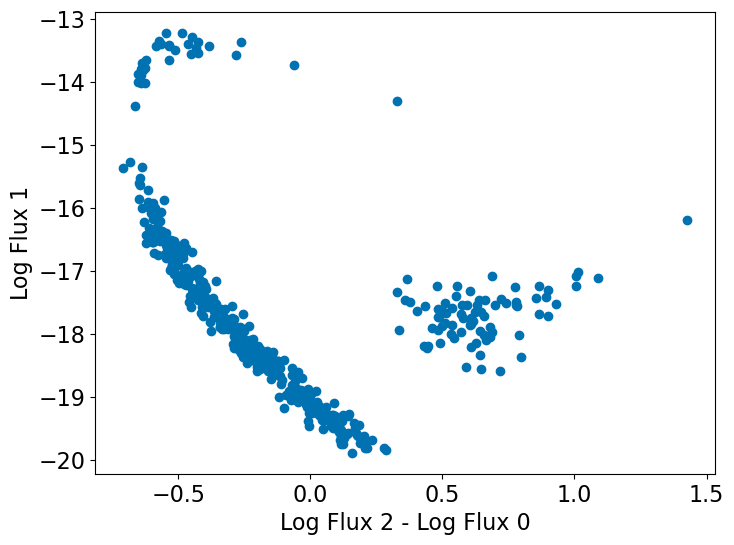

In [26]:
s = plt.scatter(colour,m1)
plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

Great! We see a main sequence and a giant branch. Let's look at the parallaxes and see if we can get an absolute distance...

In [27]:
print('Parallaxes: mean %.3f, sd %.3f' % (np.mean(galaxy['Parallax']),np.std(galaxy['Parallax'])))

Parallaxes: mean 0.000, sd 0.001


Oh dear. Look at those parallaxes - tiny, some are even negative (this is just noise, and happens in real data!). Useless for an absolute distance determination! 

## Nearby stars as benchmarks

We'll have to find out the distance to this cluster by fitting an HR diagram. Let's look at all the nearby stars and see if we can get something nice. 

We are going to make a list of every single `points.txt` file of stars in every camera. 

We use `glob` for this, which is a Python package for searching for filenames, and in this `*` is a 'wildcard' that means match *anything* here that otherwise fits the format - so this means search for `Down`, `Up`, and so forth, and `A01`, `B05` etc for the second `*`. 

In [28]:
import glob # this package lets you search for filenames
import os

all_stars = glob.glob(ddir+'*/Star_Data.csv')

Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

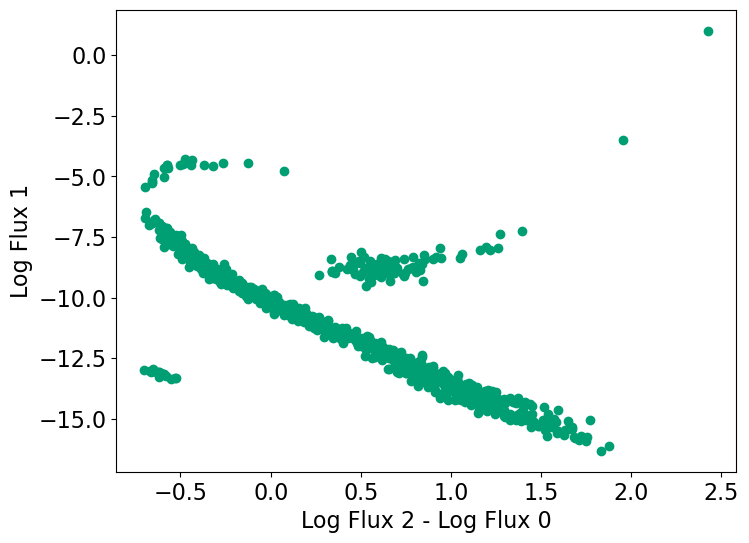

In [29]:
fig, ax1 = plt.subplots(1,1)
for j, catalog in enumerate(all_stars):
    try:
        this = pd.read_csv(catalog)
        
        thispar = this.Parallax
        thism0, thism1, thism2 = (np.log10(this.BlueF), 
                                  np.log10(this.GreenF), 
                                  np.log10(this.RedF))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist) 
        mm = thispar>0.010 # only pick the ones with good signal-to-noise - 10 mas is ok 
        
        ax1.scatter(thiscolour[mm],abs_mag[mm],color='C1')
    except:
        pass

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

Cool! There are tons of stars in here! 

## Distance Estimation

Let's estimate the distance to this cluster. Remember the inverse square law - the brightness you see is proportional to 

```
(brightness at distance d1)*(d1**2 / d2 **2)
```

What we want to do is *standardize* everything to how bright it would be at a distance of, for the sake of argument, 1 parsec. (In real research, for no particular reason, people usually use 10 parsecs for absolute magnitudes, but for simplicity we will use 1). 

If we're working in log units, `log(1/d**2) = -2*log(d)`, so this means that our standardized log flux is 

```
abs_mag = observed_mag + 2*log(dist) 
```

Now let's plot them on the same axes.

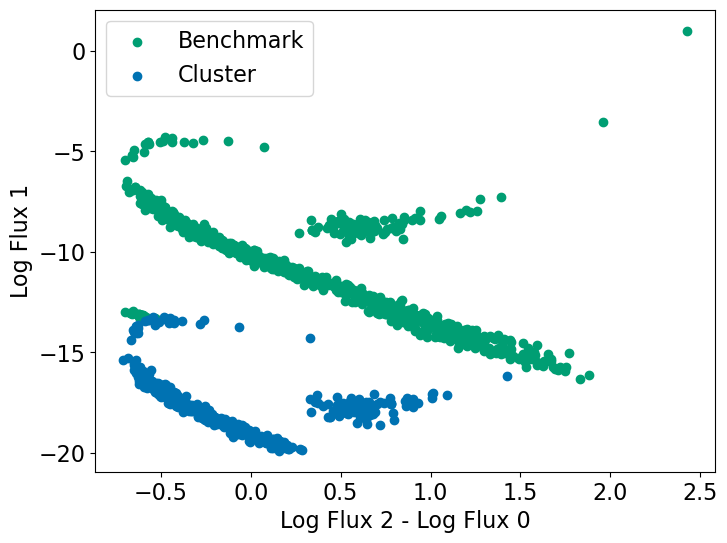

In [30]:
fig = plt.figure()

for j, catalog in enumerate(all_stars):
    try:
        this = pd.read_csv(catalog)
        
        thispar = this.Parallax
        thism0, thism1, thism2 = (np.log10(this.BlueF), 
                                  np.log10(this.GreenF), 
                                  np.log10(this.RedF))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist) 
        mm = thispar>0.010 # only pick the ones with good signal-to-noise - 10 mas is ok 
        
        h = plt.scatter(thiscolour[mm],abs_mag[mm],color='C1')
    except:
        pass

s = plt.scatter(colour,m1,color='C0')

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

plt.legend([h,s],['Benchmark','Cluster'])

So this cluster is much further away! By trial and error, let's find a distance modulus that looks right. 

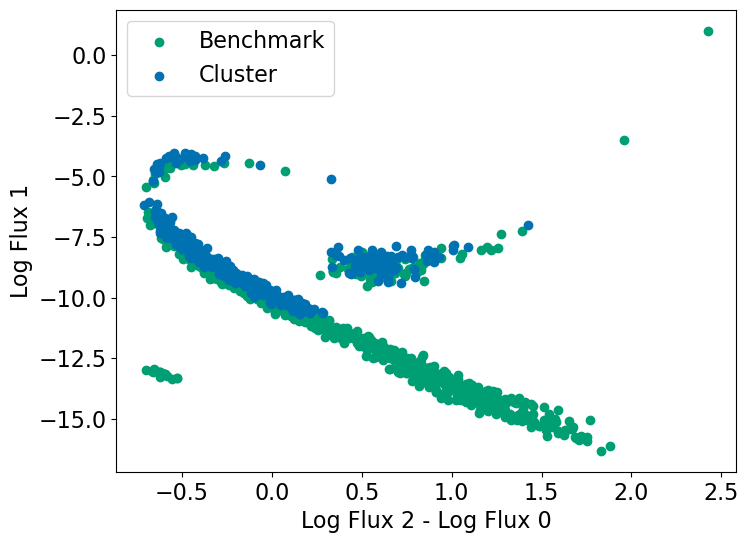

In [36]:
fig = plt.figure()

for j, catalog in enumerate(all_stars):
    try:
        this = pd.read_csv(catalog)
        
        thispar = this.Parallax
        thism0, thism1, thism2 = (np.log10(this.BlueF), 
                                  np.log10(this.GreenF), 
                                  np.log10(this.RedF))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist) 
        mm = thispar>0.010 # only pick the ones with good signal-to-noise - 10 mas is ok 
        
        h = plt.scatter(thiscolour[mm],abs_mag[mm],color='C1')
    except:
        pass

s = plt.scatter(colour,m1+9.2,color='C0')

plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

plt.legend([h,s],['Benchmark','Cluster'])

In [38]:
10**(np.array([8.8,9.0])/2)

array([25118.8643151 , 31622.77660168])

By trial and error it looks like this offset is about (8.8-9.0).

This is `2*log10(distance)` so this cluster is at a distance of 10^(8.8/2 - 9.0/2) = 25000-32000 pc. 

(I looked it up in the answers and it's 29000 pc - so a pretty decent estimate!)

## More advanced steps...

How do you think you could automate this process? Do you think you could

- identify all the galaxies at once, perhaps by using a [clustering algorithm](https://scikit-learn.org/stable/modules/clustering.html)?
- Get a more accurate HR diagram fitting, perhaps by using [kernel density estimation](https://scikit-learn.org/stable/modules/density.html)?
- Could you get a rotation curve of this galaxy? What is its mass? Does it have a black hole?